In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime, timedelta
import subprocess

In [2]:
def read_file(filename):
    names, errors, shape = [], [], []
    with open(filename, 'r') as file:
        for line in file:
            # Split the line into its components using whitespace as the delimiter
            parts = line.strip().split()
            # Extract the "name", "val1", and "val2" from the parts list
            names.append(parts[0])
            errors.append(float(parts[1]))
            shape.append(float(parts[2]))
    return names, errors, shape

def time_difference_in_seconds(time_str1, time_str2):
    # Convert time strings to datetime objects
    time_format = "%H:%M:%S"
    time1 = datetime.strptime(time_str1, time_format)
    time2 = datetime.strptime(time_str2, time_format)

    # Calculate the time difference in seconds
    time_difference = (time2 - time1).total_seconds()

    return time_difference

def getTimeIntervals(times, n=1):
    diffs = []
    for i in range(len(times[:-n:n])):
        diffs.append(time_difference_in_seconds(times[i*n], times[i*n+n]))
    return np.asarray(diffs)

def getJobsIntervals(jobs, n=1):
    diffs = []
    for i in range(len(jobs[:-n:n])):
        diffs.append(jobs[i*n+n] - jobs[i*n])
    return np.asarray(diffs)

def getJobsPerMinute(jobDiffs, timeDiffs):
    return jobDiffs/timeDiffs*60.0

1076


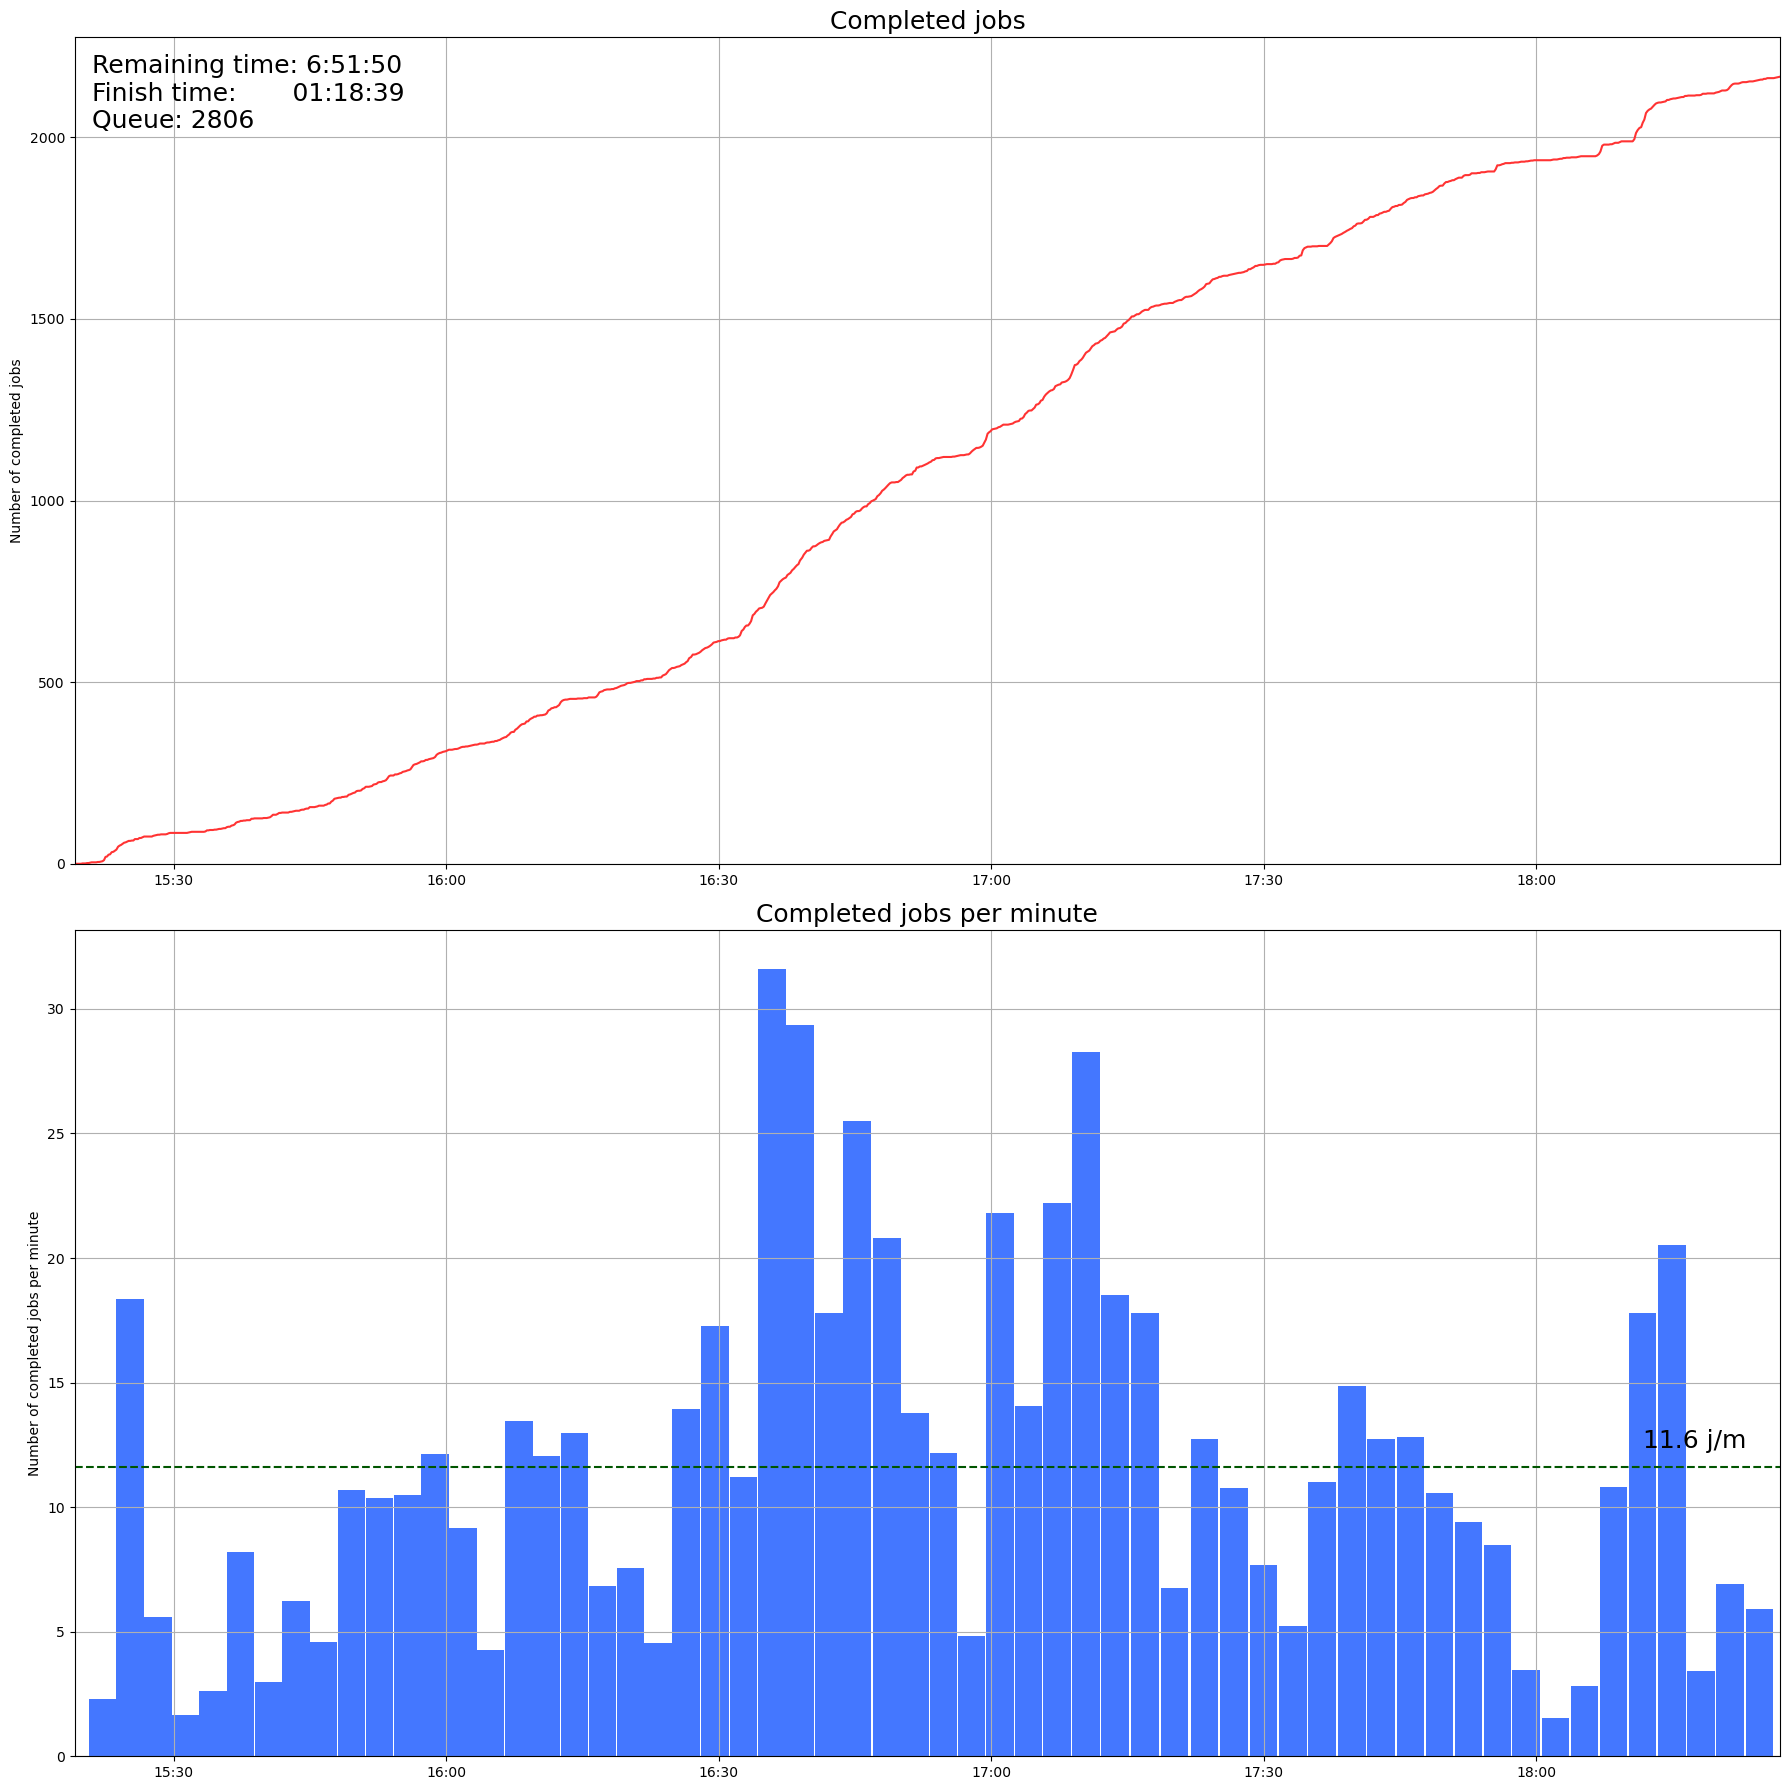

In [7]:
arrs = read_file("timeJobs.txt")
print(len(arrs[0]))
time_format = "%H:%M:%S"
# Calculate the regression line using scipy's linregress function
slope, intercept, r_value, p_value, std_err = stats.linregress([datetime.strptime(t, time_format).hour*60 + datetime.strptime(t, time_format).minute for t in arrs[0][-360:]], arrs[1][-360:])

nTotJobs = 5995

remainingTime = "Remaining time: {}:{:02d}:{:02d}".format(int((nTotJobs - arrs[1][-1])/slope/60), int(((nTotJobs - arrs[1][-1])/slope)%60), int(((((nTotJobs - arrs[1][-1])/slope))%1)*60))
time_obj_seconds = timedelta(seconds=(nTotJobs - arrs[1][-1])/slope*60)
finish_datetime = datetime.strptime(arrs[0][-1], time_format) + time_obj_seconds
finishTime = "Finish time:       {}".format(finish_datetime.time().strftime("%H:%M:%S"))
queuedJobs = subprocess.run("squeue --me | wc -l", shell=True, capture_output=True, text=True).stdout

#print(remainingTime)
#print(finishTime)

time_format_axis = "%H:%M"
x_min = datetime.strptime(arrs[0][0], time_format)
x_max = datetime.strptime(arrs[0][-1], time_format)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 18))

ax1.plot([datetime.strptime(t, time_format) for t in arrs[0]], arrs[1], color="#ff3333")
ax1.annotate(remainingTime + "\n" + finishTime + "\n" + "Queue: " + str(queuedJobs), xy=(0.01, 0.98), xycoords='axes fraction', fontsize=18, horizontalalignment='left', verticalalignment='top')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(time_format_axis))
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(0)
ax1.set_ylabel('Number of completed jobs')
ax1.set_title('Completed jobs', fontsize=18)
ax1.grid()

corse=max((x_max-x_min).seconds//3600, 1)

n=6*corse
jobsPM = getJobsPerMinute(getJobsIntervals(arrs[1], n=n), getTimeIntervals(arrs[0], n=n))
meanJPM = np.mean(jobsPM)

ax2.bar([datetime.strptime(t, time_format) for t in arrs[0][n::n]][-len(jobsPM):], jobsPM, color="#4477ff", width=0.0007*corse)
ax2.axhline(y=meanJPM, color='#005500', linestyle='--')
ax2.annotate(str(round(meanJPM, 2)) + " j/m", xy=(0.98, meanJPM/np.max(jobsPM)), xycoords='axes fraction', fontsize=18, horizontalalignment='right', verticalalignment='bottom')
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(time_format_axis))
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(0)
ax2.set_ylabel('Number of completed jobs per minute')
ax2.set_title('Completed jobs per minute', fontsize=18)
ax2.grid()

plt.tight_layout()
plt.savefig('/home/submit/pdmonte/public_html/jobs.png')
plt.show()
